In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix


# Question 1: Function to calculate Gini impurity
def calculate_gini_impurity(y):
    """
    Calculate the Gini impurity of a node
    
    Parameters
    ----------
    y : ndarray of shape (n_samples,)
        Class labels of samples in the node
        
    Returns
    -------
    float
        Gini impurity value
    """
    if len(y) == 0:
        return 0.0
    
    # Count occurrences of each class
    _, counts = np.unique(y, return_counts=True)
    
    # Calculate proportions
    proportions = counts / len(y)
    
    # Calculate Gini impurity
    gini = 1 - np.sum(proportions ** 2)
    
    return gini


In [2]:
# Question 2: Function to calculate information gain
def calculate_information_gain(y_parent, y_left, y_right):
    """
    Calculate the information gain between parent node and its children
    
    Parameters
    ----------
    y_parent : ndarray of shape (n_samples,)
        Class labels of samples in the parent node
    y_left : ndarray of shape (n_left_samples,)
        Class labels of samples in the left child node
    y_right : ndarray of shape (n_right_samples,)
        Class labels of samples in the right child node
        
    Returns
    -------
    float
        Information gain value
    """
    # Calculate parent node impurity
    impurity_parent = calculate_gini_impurity(y_parent)
    
    # Calculate weighted impurities of children
    n_parent = len(y_parent)
    n_left = len(y_left)
    n_right = len(y_right)
    
    weight_left = n_left / n_parent
    weight_right = n_right / n_parent
    
    impurity_left = calculate_gini_impurity(y_left)
    impurity_right = calculate_gini_impurity(y_right)
    
    # Calculate information gain
    information_gain = impurity_parent - (weight_left * impurity_left + weight_right * impurity_right)
    
    return information_gain


In [3]:
# Depth 1 Decision Tree Classifier
class ScratchDecisionTreeClassifierDepth1:
    """
    Depth 1 decision tree classifier from scratch
    
    Parameters
    ----------
    verbose : bool
        If True, print learning process
    """
    
    def __init__(self, verbose=False):
        # Hyperparameters as attributes
        self.verbose = verbose
        
        # Parameters to be learned
        self.feature_idx = None
        self.threshold = None
        self.classes = None
        self.left_class = None
        self.right_class = None
    
    def fit(self, X, y):
        """
        Train the decision tree classifier
        
        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Training data features
        y : ndarray of shape (n_samples,)
            Training data labels
        """
        n_samples, n_features = X.shape
        
        # Store classes
        self.classes = np.unique(y)
        
        best_gain = -np.inf
        best_feature = None
        best_threshold = None
        best_left_indices = None
        best_right_indices = None
        
        # Try all features
        for feature_idx in range(n_features):
            feature_values = X[:, feature_idx]
            thresholds = np.unique(feature_values)
            
            # Try all possible thresholds
            for threshold in thresholds:
                # Split based on threshold
                left_indices = np.where(feature_values < threshold)[0]
                right_indices = np.where(feature_values >= threshold)[0]
                
                # Skip if either split is empty
                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue
                
                # Calculate information gain
                gain = calculate_information_gain(
                    y, 
                    y[left_indices], 
                    y[right_indices]
                )
                
                # Update if better split found
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold
                    best_left_indices = left_indices
                    best_right_indices = right_indices
        
        # Store best split parameters
        self.feature_idx = best_feature
        self.threshold = best_threshold
        
        # Determine majority class for each branch
        if len(best_left_indices) > 0:
            left_classes, left_counts = np.unique(y[best_left_indices], return_counts=True)
            self.left_class = left_classes[np.argmax(left_counts)]
        else:
            self.left_class = np.argmax(np.bincount(y))
            
        if len(best_right_indices) > 0:
            right_classes, right_counts = np.unique(y[best_right_indices], return_counts=True)
            self.right_class = right_classes[np.argmax(right_counts)]
        else:
            self.right_class = np.argmax(np.bincount(y))
        
        if self.verbose:
            print(f"Best feature: {best_feature}")
            print(f"Best threshold: {best_threshold}")
            print(f"Best information gain: {best_gain}")
            print(f"Left class: {self.left_class}")
            print(f"Right class: {self.right_class}")
    
    def predict(self, X):
        """
        Use the decision tree classifier to predict labels
        
        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Features to predict
            
        Returns
        -------
        ndarray of shape (n_samples,)
            Predicted class labels
        """
        n_samples = X.shape[0]
        predictions = np.zeros(n_samples)
        
        # Apply split criterion to each sample
        feature_values = X[:, self.feature_idx]
        left_mask = feature_values < self.threshold
        right_mask = ~left_mask
        
        # Assign classes based on split
        predictions[left_mask] = self.left_class
        predictions[right_mask] = self.right_class
        
        return predictions




In [4]:
# Node class for deeper decision trees
class Node:
    """
    Node class for decision trees
    """
    def __init__(self, depth=0, max_depth=None):
        self.feature_idx = None
        self.threshold = None
        self.left = None
        self.right = None
        self.class_label = None
        self.depth = depth
        self.max_depth = max_depth
        self.is_leaf = False
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Check if max depth reached or pure node or only one sample
        if (self.max_depth is not None and self.depth >= self.max_depth) or len(np.unique(y)) == 1 or len(y) <= 1:
            self.is_leaf = True
            # Assign majority class
            unique_classes, counts = np.unique(y, return_counts=True)
            self.class_label = unique_classes[np.argmax(counts)]
            return
        
        best_gain = -np.inf
        best_feature = None
        best_threshold = None
        best_left_indices = None
        best_right_indices = None
        
        # Try all features
        for feature_idx in range(n_features):
            feature_values = X[:, feature_idx]
            thresholds = np.unique(feature_values)
            
            # Try all possible thresholds
            for threshold in thresholds:
                # Split based on threshold
                left_indices = np.where(feature_values < threshold)[0]
                right_indices = np.where(feature_values >= threshold)[0]
                
                # Skip if either split is empty
                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue
                
                # Calculate information gain
                gain = calculate_information_gain(
                    y, 
                    y[left_indices], 
                    y[right_indices]
                )
                
                # Update if better split found
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold
                    best_left_indices = left_indices
                    best_right_indices = right_indices
        
        # If no good split found, make it a leaf
        if best_gain <= 0:
            self.is_leaf = True
            # Assign majority class
            unique_classes, counts = np.unique(y, return_counts=True)
            self.class_label = unique_classes[np.argmax(counts)]
            return
        
        # Store best split parameters
        self.feature_idx = best_feature
        self.threshold = best_threshold
        
        # Create and train child nodes
        self.left = Node(depth=self.depth + 1, max_depth=self.max_depth)
        self.right = Node(depth=self.depth + 1, max_depth=self.max_depth)
        
        self.left.fit(X[best_left_indices], y[best_left_indices])
        self.right.fit(X[best_right_indices], y[best_right_indices])
    
    def predict_sample(self, x):
        if self.is_leaf:
            return self.class_label
        
        if x[self.feature_idx] < self.threshold:
            return self.left.predict_sample(x)
        else:
            return self.right.predict_sample(x)



In [5]:
# Question 7: Depth 2 Decision Tree Classifier
class ScratchDecisionTreeClassifierDepth2:
    """
    Depth 2 decision tree classifier from scratch
    
    Parameters
    ----------
    verbose : bool
        If True, print learning process
    """
    
    def __init__(self, verbose=False):
        self.verbose = verbose
        self.root = Node(max_depth=2)
    
    def fit(self, X, y):
        """
        Train the decision tree classifier
        
        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Training data features
        y : ndarray of shape (n_samples,)
            Training data labels
        """
        self.classes = np.unique(y)
        self.root.fit(X, y)
        
        if self.verbose:
            print("Trained depth 2 decision tree")
    
    def predict(self, X):
        """
        Use the decision tree classifier to predict labels
        
        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Features to predict
            
        Returns
        -------
        ndarray of shape (n_samples,)
            Predicted class labels
        """
        n_samples = X.shape[0]
        predictions = np.zeros(n_samples)
        
        for i in range(n_samples):
            predictions[i] = self.root.predict_sample(X[i])
        
        return predictions


In [6]:
# Question 8: Unlimited Depth Decision Tree Classifier
class ScratchDecisionTreeClassifierDepthInf:
    """
    Decision tree classifier with unlimited depth from scratch
    
    Parameters
    ----------
    max_depth : int or None
        Maximum depth of the tree. If None, grow until all leaf nodes have
        gini impurity 0
    verbose : bool
        If True, print learning process
    """
    
    def __init__(self, max_depth=None, verbose=False):
        self.max_depth = max_depth
        self.verbose = verbose
        self.root = Node(max_depth=max_depth)
    
    def fit(self, X, y):
        """
        Train the decision tree classifier
        
        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Training data features
        y : ndarray of shape (n_samples,)
            Training data labels
        """
        self.classes = np.unique(y)
        self.root.fit(X, y)
        
        if self.verbose:
            if self.max_depth is None:
                print("Trained decision tree with unlimited depth")
            else:
                print(f"Trained decision tree with maximum depth {self.max_depth}")
    
    def predict(self, X):
        """
        Use the decision tree classifier to predict labels
        
        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Features to predict
            
        Returns
        -------
        ndarray of shape (n_samples,)
            Predicted class labels
        """
        n_samples = X.shape[0]
        predictions = np.zeros(n_samples)
        
        for i in range(n_samples):
            predictions[i] = self.root.predict_sample(X[i])
        
        return predictions

In [7]:
def plot_decision_regions(X, y, classifier, resolution=0.01, title="Decision Regions"):
    """
    Visualize decision regions for a classifier
    
    Parameters
    ----------
    X : ndarray of shape (n_samples, 2)
        Features (only works with 2 features)
    y : ndarray of shape (n_samples,)
        Class labels
    classifier : object
        Trained classifier with predict method
    resolution : float
        Grid resolution
    title : str
        Plot title
    """
    # Setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    
    # Plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    plt.figure(figsize=(10, 8))
    plt.contourf(xx1, xx2, Z, alpha=0.3)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # Plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                   y=X[y == cl, 1],
                   alpha=0.8, 
                   c=colors[idx % len(colors)],
                   marker=markers[idx % len(markers)],
                   label=f'Class {cl}')
    
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(loc='upper left')
    plt.show()


Testing Gini impurity calculation...
Example 1: 0.500 (expected: 0.500)
Example 2: 0.667 (expected: 0.667)
Example 3: 0.480 (expected: 0.480)
Example 4: 0.000 (expected: 0.000)

Testing information gain calculation...
Information gain: 0.143 (expected: 0.143)

Testing with simple dataset...

Training depth 1 decision tree...
Best feature: 0
Best threshold: 1.622330632042909
Best information gain: 0.4319157636475158
Left class: 0.0
Right class: 1.0

Results for depth 1 decision tree:
Accuracy: 0.9333
Precision: 1.0000
Recall: 0.8667
Confusion Matrix:
[[30  0]
 [ 4 26]]

Training scikit-learn decision tree (max_depth=1)...

Results for scikit-learn decision tree (max_depth=1):
Accuracy: 0.9333
Precision: 1.0000
Recall: 0.8667
Confusion Matrix:
[[30  0]
 [ 4 26]]

Visualizing decision regions for depth 1 tree...


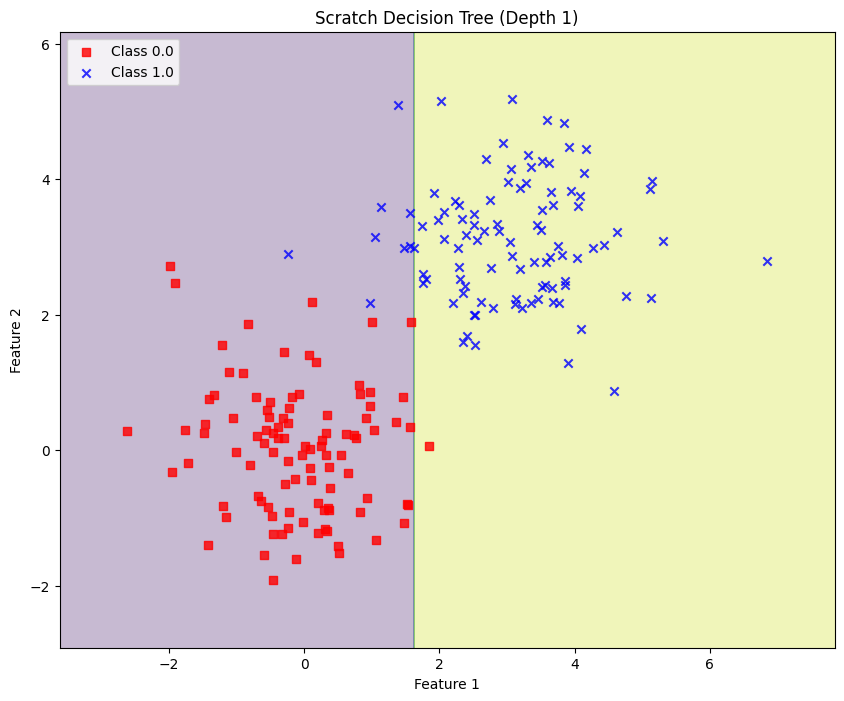

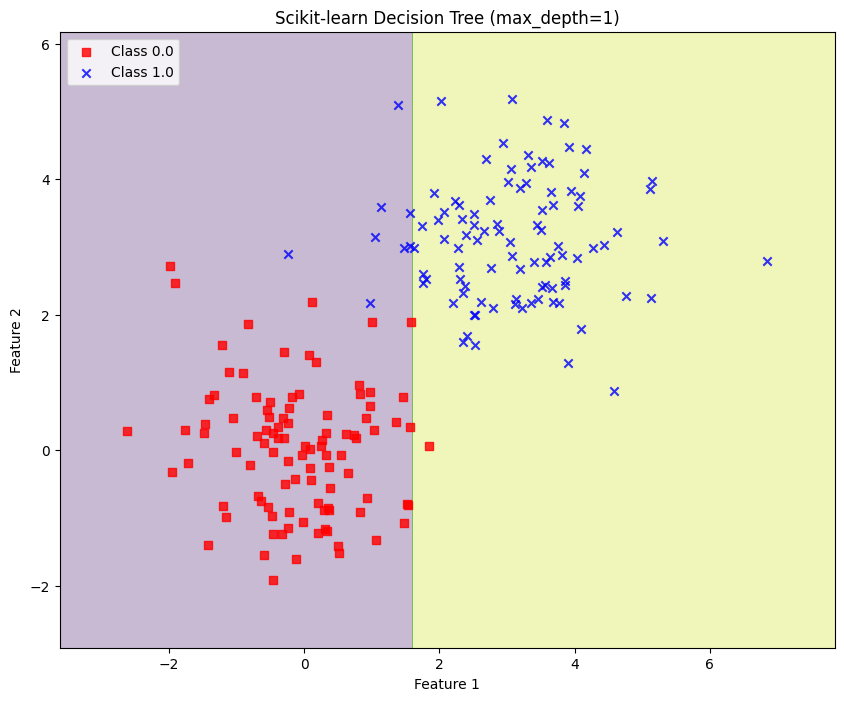


Training depth 2 decision tree...
Trained depth 2 decision tree

Results for depth 2 decision tree:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
Confusion Matrix:
[[30  0]
 [ 0 30]]

Training scikit-learn decision tree (max_depth=2)...

Results for scikit-learn decision tree (max_depth=2):
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
Confusion Matrix:
[[30  0]
 [ 0 30]]

Visualizing decision regions for depth 2 tree...


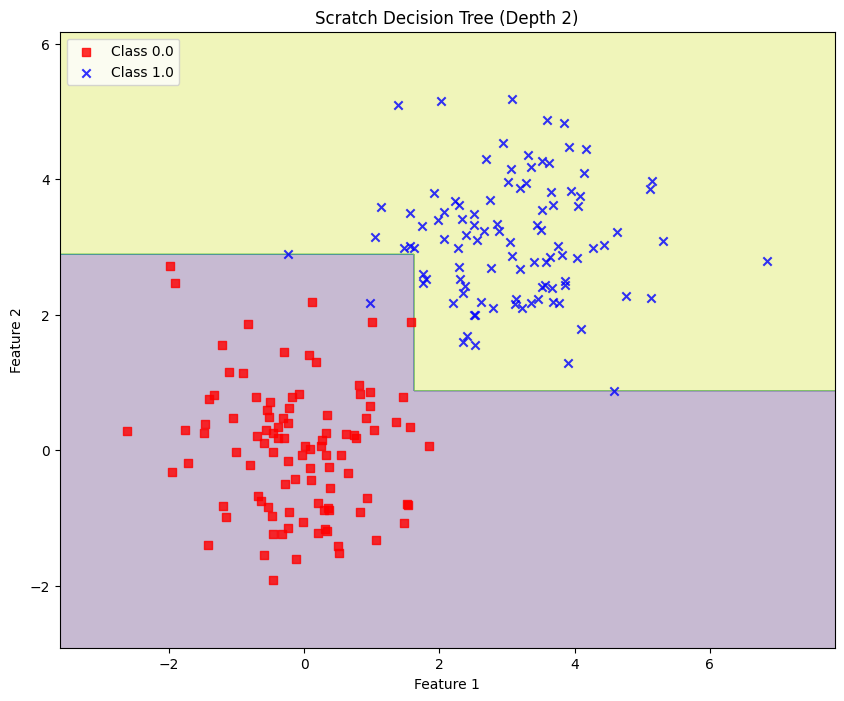

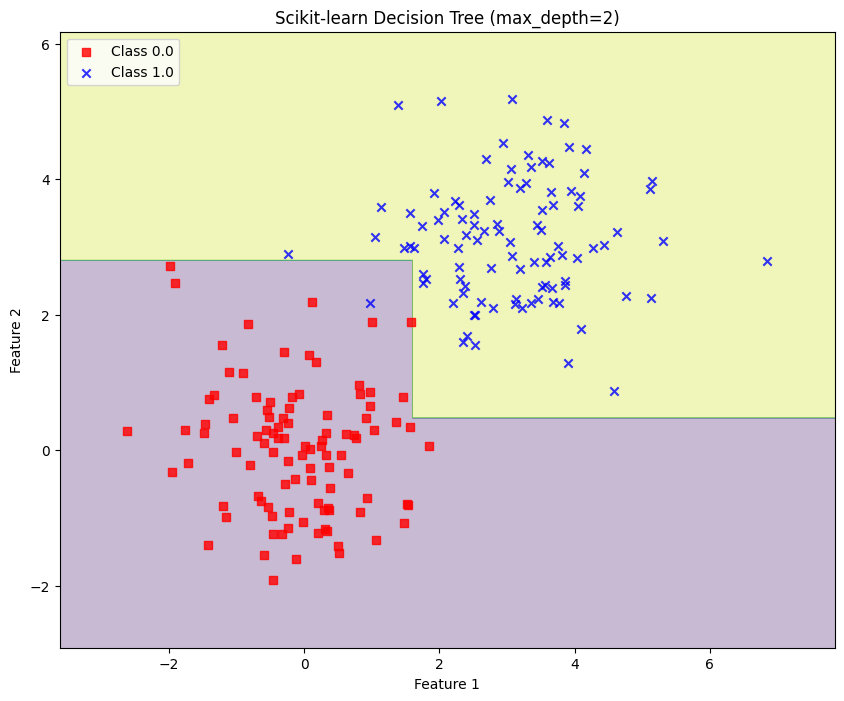


Training unlimited depth decision tree...
Trained decision tree with unlimited depth

Results for unlimited depth decision tree:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
Confusion Matrix:
[[30  0]
 [ 0 30]]

Training scikit-learn decision tree (unlimited depth)...

Results for scikit-learn decision tree (unlimited depth):
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
Confusion Matrix:
[[30  0]
 [ 0 30]]

Visualizing decision regions for unlimited depth tree...


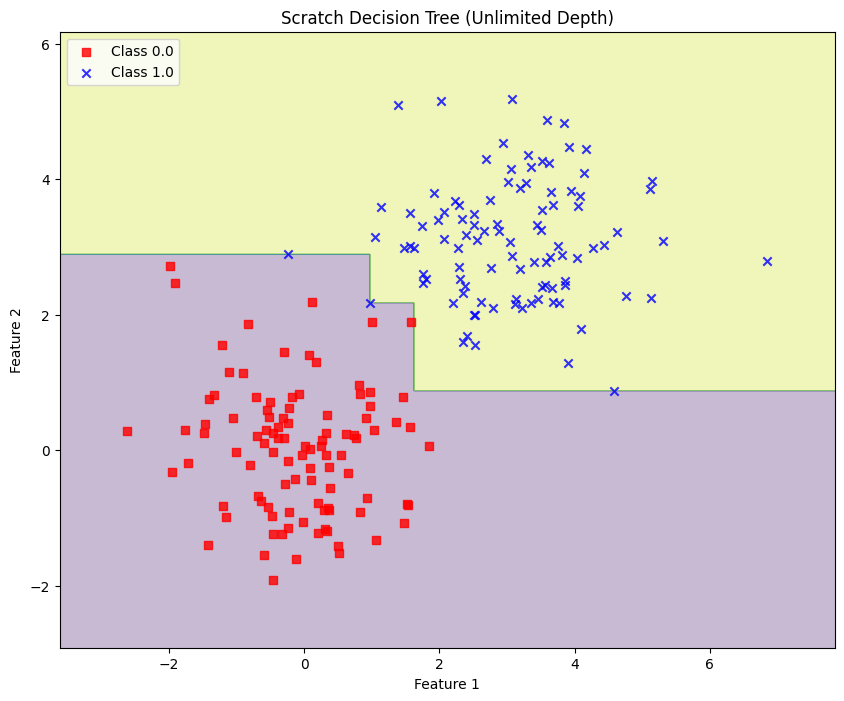

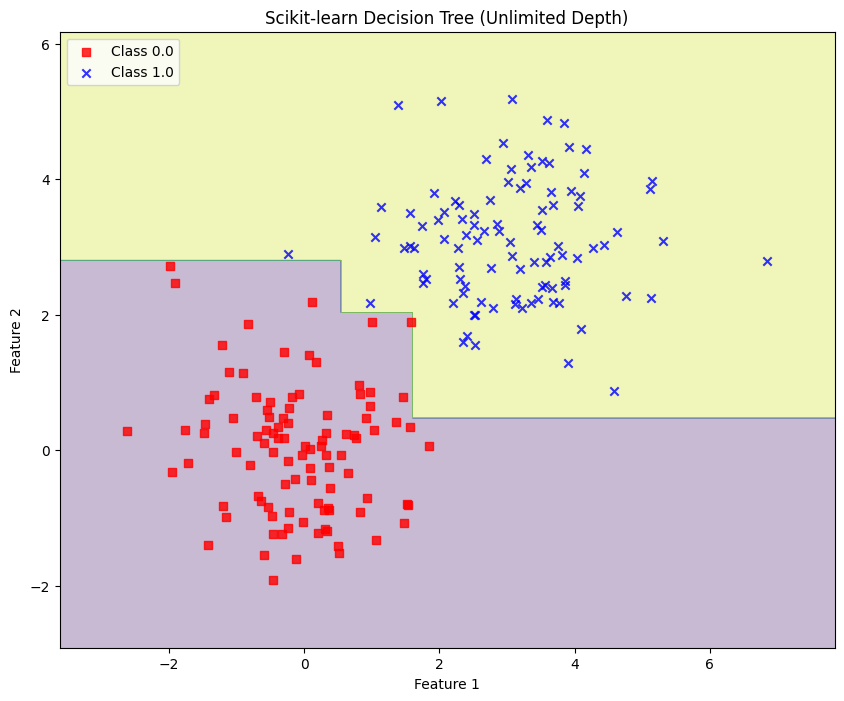

In [8]:
def test_gini_impurity():
    print("Testing Gini impurity calculation...")
    
    # Example 1: Class 1: 15 samples, Class 2: 15 samples
    example1 = np.array([0] * 15 + [1] * 15)
    gini1 = calculate_gini_impurity(example1)
    print(f"Example 1: {gini1:.3f} (expected: 0.500)")
    
    # Example 2: Class 1: 15 samples, Class 2: 15 samples, Class 3: 15 samples
    example2 = np.array([0] * 15 + [1] * 15 + [2] * 15)
    gini2 = calculate_gini_impurity(example2)
    print(f"Example 2: {gini2:.3f} (expected: 0.667)")
    
    # Example 3: Class 1: 18 samples, Class 2: 12 samples
    example3 = np.array([0] * 18 + [1] * 12)
    gini3 = calculate_gini_impurity(example3)
    print(f"Example 3: {gini3:.3f} (expected: 0.480)")
    
    # Example 4: Class 1: 30 samples, Class 2: 0 samples
    example4 = np.array([0] * 30)
    gini4 = calculate_gini_impurity(example4)
    print(f"Example 4: {gini4:.3f} (expected: 0.000)")


# Test with simple examples for information gain
def test_information_gain():
    print("\nTesting information gain calculation...")
    
    # Example: Left node class 1: 10 samples, left node class 2: 30 samples, 
    # right node class 1: 20 samples, right node class 2: 5 samples
    parent = np.array([0] * 30 + [1] * 35)
    left = np.array([0] * 10 + [1] * 30)
    right = np.array([0] * 20 + [1] * 5)
    
    gain = calculate_information_gain(parent, left, right)
    print(f"Information gain: {gain:.3f} (expected: 0.143)")


# Generate simple dataset for testing
def generate_simple_dataset():
    np.random.seed(42)
    
    # Generate two clusters
    n_samples = 100
    X = np.zeros((n_samples * 2, 2))
    y = np.zeros(n_samples * 2)
    
    # First cluster
    X[:n_samples, 0] = np.random.normal(loc=0, scale=1, size=n_samples)
    X[:n_samples, 1] = np.random.normal(loc=0, scale=1, size=n_samples)
    y[:n_samples] = 0
    
    # Second cluster
    X[n_samples:, 0] = np.random.normal(loc=3, scale=1, size=n_samples)
    X[n_samples:, 1] = np.random.normal(loc=3, scale=1, size=n_samples)
    y[n_samples:] = 1
    
    return X, y


# Test with Simple Dataset 2
def test_with_simple_dataset():
    print("\nTesting with simple dataset...")
    
    # Generate dataset
    X, y = generate_simple_dataset()
    
    # Split data into train and test sets
    np.random.seed(42)
    indices = np.random.permutation(len(X))
    train_size = int(0.7 * len(X))
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    
    # Train and evaluate depth 1 tree
    print("\nTraining depth 1 decision tree...")
    dt1 = ScratchDecisionTreeClassifierDepth1(verbose=True)
    dt1.fit(X_train, y_train)
    
    y_pred_dt1 = dt1.predict(X_test)
    
    print("\nResults for depth 1 decision tree:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_dt1):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_dt1):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_dt1):.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_dt1)}")
    
    # Compare with scikit-learn
    print("\nTraining scikit-learn decision tree (max_depth=1)...")
    sklearn_dt1 = DecisionTreeClassifier(max_depth=1, random_state=42)
    sklearn_dt1.fit(X_train, y_train)
    
    y_pred_sklearn_dt1 = sklearn_dt1.predict(X_test)
    
    print("\nResults for scikit-learn decision tree (max_depth=1):")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_sklearn_dt1):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_sklearn_dt1):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_sklearn_dt1):.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_sklearn_dt1)}")
    
    # Visualize decision regions
    print("\nVisualizing decision regions for depth 1 tree...")
    plot_decision_regions(X, y, dt1, title="Scratch Decision Tree (Depth 1)")
    plot_decision_regions(X, y, sklearn_dt1, title="Scikit-learn Decision Tree (max_depth=1)")
    
    # Test depth 2 tree
    print("\nTraining depth 2 decision tree...")
    dt2 = ScratchDecisionTreeClassifierDepth2(verbose=True)
    dt2.fit(X_train, y_train)
    
    y_pred_dt2 = dt2.predict(X_test)
    
    print("\nResults for depth 2 decision tree:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_dt2):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_dt2):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_dt2):.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_dt2)}")
    
    # Compare with scikit-learn
    print("\nTraining scikit-learn decision tree (max_depth=2)...")
    sklearn_dt2 = DecisionTreeClassifier(max_depth=2, random_state=42)
    sklearn_dt2.fit(X_train, y_train)
    
    y_pred_sklearn_dt2 = sklearn_dt2.predict(X_test)
    
    print("\nResults for scikit-learn decision tree (max_depth=2):")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_sklearn_dt2):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_sklearn_dt2):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_sklearn_dt2):.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_sklearn_dt2)}")
    
    # Visualize decision regions
    print("\nVisualizing decision regions for depth 2 tree...")
    plot_decision_regions(X, y, dt2, title="Scratch Decision Tree (Depth 2)")
    plot_decision_regions(X, y, sklearn_dt2, title="Scikit-learn Decision Tree (max_depth=2)")
    
    # Test unlimited depth tree
    print("\nTraining unlimited depth decision tree...")
    dt_inf = ScratchDecisionTreeClassifierDepthInf(verbose=True)
    dt_inf.fit(X_train, y_train)
    
    y_pred_dt_inf = dt_inf.predict(X_test)
    
    print("\nResults for unlimited depth decision tree:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_dt_inf):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_dt_inf):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_dt_inf):.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_dt_inf)}")
    
    # Compare with scikit-learn
    print("\nTraining scikit-learn decision tree (unlimited depth)...")
    sklearn_dt_inf = DecisionTreeClassifier(random_state=42)
    sklearn_dt_inf.fit(X_train, y_train)
    
    y_pred_sklearn_dt_inf = sklearn_dt_inf.predict(X_test)
    
    print("\nResults for scikit-learn decision tree (unlimited depth):")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_sklearn_dt_inf):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_sklearn_dt_inf):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_sklearn_dt_inf):.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_sklearn_dt_inf)}")
    
    # Visualize decision regions
    print("\nVisualizing decision regions for unlimited depth tree...")
    plot_decision_regions(X, y, dt_inf, title="Scratch Decision Tree (Unlimited Depth)")
    plot_decision_regions(X, y, sklearn_dt_inf, title="Scikit-learn Decision Tree (Unlimited Depth)")


if __name__ == "__main__":
    # Test Gini impurity calculation
    test_gini_impurity()
    
    # Test information gain calculation
    test_information_gain()
    
    # Test with simple dataset
    test_with_simple_dataset()